# Multiscale Modeling of the Sustainable Production of 1,3-PDO and 3HP
## Stage 4. Economy-scale Modeling and Analysis

In [1]:
%reset -f
%load_ext autoreload
%autoreload 2
from __future__ import division

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## 4.1 Creating Economy-scale Model

In [2]:
from cbmTES.global_constants import *
import cbmTES.agriculture as agriculture
import cbmTES.energy as energy
import cbmTES.market as market
import cbmTES.biochemical as biochemical

from framed.core.models import Metabolite, Reaction, Compartment, ConstraintBasedModel
from framed.io_utils.plaintext import add_reaction_from_str
from framed.analysis.simulation import FBA, pFBA

from framed.hack.ratio_constraint import *

import matplotlib.pyplot as plt

#### 1. Creating Model

In [41]:
model = ConstraintBasedModel('Biochemical Industry Model (glc, glyc, pdo, 3hp)')

#### 2. Creating Compartments
The model contains six sectors.  Each sector is represented as a compartment.

In [42]:
#env = Compartment('env', 'environment')
mkt = Compartment('mkt','market')
res = Compartment('res','resource')
erg = Compartment('erg','energy')
agr = Compartment('agr', 'agriculture')
bch = Compartment('bch','biochemical industry')

#model.add_compartments([env, mkt, res, erg, agr, bch])
model.add_compartments([mkt, res, erg, agr, bch])


#### 3. Market Compartment

In [43]:
## adding metabolites
#metabolites_list = ['land', 'petroleum', 'natural_gas', 'coal', 'co2e', 'po4e', 'waste_organic', 'waste_cellulosic', 'glc','glyc','1,3pdo','3hp','biomass','soymeal','biodiesel', 'energy', 'dollar']
metabolites_list = ['land', 'petroleum', 'natural_gas', 'coal', 'co2e', 'po4e', 'waste_organic', 'waste_cellulosic', 'waste_inorganic', 'glc','glyc','1,3pdo','3hp','biomass','soymeal','biodiesel', 'energy', 'dollar', 'lime', 'sulfuric_acid']
metabolites = [Metabolite(m + '_mkt', compartment='mkt') for m in metabolites_list]
model.add_metabolites(metabolites)

## Price Information
prices_list = market.prices.keys()

# Environmental Exchange
    # resource consumption fluxes: -ve
    # environmental emission fluxes: +ve
metabolites_list = ['co2e', 'po4e', 'waste_organic', 'waste_cellulosic', 'waste_inorganic', 'lime', 'sulfuric_acid']
for m in metabolites_list:
    rxn = Reaction('EX_' + m + '_mkt', reversible=True)
    model.add_reaction(rxn)
    model.stoichiometry[(m + '_mkt',rxn.id)]= -1
    if m in prices_list:
        model.stoichiometry[('dollar_mkt',rxn.id)]= market.prices[m]

# market product demands
    # import demand : -ve (entering market)
    # export demand : +ve (leaving market)
metabolites_list = ['glc','glyc','1,3pdo','3hp','biomass','soymeal','biodiesel', 'energy']
for m in metabolites_list:
    rxn = Reaction('DM_' + m + '_mkt', reversible=True)
    model.add_reaction(rxn)
    model.stoichiometry[(m + '_mkt',rxn.id)]= -1
    if m in prices_list:
        model.stoichiometry[('dollar_mkt',rxn.id)]= market.prices[m]
    

####4. Resource Sector

In [44]:
## adding metabolites
metabolites_list = ['land', 'petroleum', 'natural_gas', 'coal', 'dollar']
metabolites = [Metabolite(m + '_res', compartment='res') for m in metabolites_list]
model.add_metabolites(metabolites)

# Environmental Exchange
    # resource consumption fluxes: -ve
    # environmental emission fluxes: +ve
metabolites_list = ['land', 'petroleum', 'natural_gas', 'coal']
for m in metabolites_list:
    rxn = Reaction('EX_' + m + '_res', reversible=True)
    model.add_reaction(rxn)
    model.stoichiometry[(m + '_res',rxn.id)]= -1
    #if m in prices_list:
    #    model.stoichiometry[('dollar_mkt',rxn.id)]= market.prices[m]
        
## Market Exchange with Resource Sector ##
metabolites_list = ['land', 'petroleum', 'natural_gas', 'coal']
for m in metabolites_list:
    rxn = Reaction('MX' + '_res2mkt_' + m, reversible=True)
    model.add_reaction(rxn)
    model.stoichiometry[(m + '_res',rxn.id)]= -1
    model.stoichiometry[(m + '_mkt',rxn.id)]= 1
    if m in prices_list:
        model.stoichiometry[('dollar_mkt',rxn.id)]= -market.prices[m]
        model.stoichiometry[('dollar_res',rxn.id)]= market.prices[m]  
        
# Resource Sector Profit
    rxn = Reaction('PROFIT_res', reversible=True)
    model.add_reaction(rxn)
    model.stoichiometry[('dollar_res',rxn.id)]= -1

In [45]:
model.metabolites['petroleum_res']

<framed.core.models.Metabolite instance at 0x10f211ef0>

#### 4. Agriculture Sector

In [46]:
## adding metabolites
metabolites_list = ['land', 'po4e', 'waste_organic', 'waste_cellulosic','glc', 'glyc', 'soymeal', 'biodiesel', 'energy','corn', 'starch', 'soy', 'soymeal', 'soyoil', 'dollar']
metabolites = [Metabolite(m + '_agr', compartment='agr') for m in metabolites_list]
model.add_metabolites(metabolites)
    
## Market Exchange with Agricultural Sector ##
metabolites_list = ['land', 'po4e', 'waste_organic', 'waste_cellulosic', 'glc', 'glyc', 'soymeal', 'biodiesel', 'energy']
for m in metabolites_list:
    rxn = Reaction('MX' + '_agr2mkt_' + m, reversible=True)
    model.add_reaction(rxn)
    model.stoichiometry[(m + '_agr',rxn.id)]= -1
    model.stoichiometry[(m + '_mkt',rxn.id)]= 1
    if m in prices_list:
        model.stoichiometry[('dollar_mkt',rxn.id)]= -market.prices[m]
        model.stoichiometry[('dollar_agr',rxn.id)]= market.prices[m]      
    
# Agricultural Processes
metabolites_list = ['corn', 'starch', 'soy', 'soymeal', 'soyoil']
for reaction in agriculture.stoichiometry:
    rxn = Reaction(reaction, reversible = agriculture.reversibility[reaction])
    model.add_reaction(rxn)
    for metabolite in agriculture.stoichiometry[reaction]:
        model.stoichiometry[metabolite+ '_agr', reaction] = agriculture.stoichiometry[reaction][metabolite]

# Agricultural Sector Profit
    rxn = Reaction('PROFIT_agr', reversible=True)
    model.add_reaction(rxn)
    model.stoichiometry[('dollar_agr',rxn.id)]= -1
    

#### 5. Energy Sector

In [47]:
## Adding Metabolites
metabolites_list = ['petroleum', 'natural_gas', 'coal' , 'co2e', 'energy', 'biodiesel', 'dollar']
metabolites = [Metabolite(m + '_erg', compartment='erg') for m in metabolites_list]
model.add_metabolites(metabolites)
    
## Market Exchange with Energy Sector ##
metabolites_list = ['petroleum', 'natural_gas', 'coal' , 'co2e', 'energy', 'biodiesel']
for m in metabolites_list:
    rxn = Reaction('MX' + '_erg2mkt_' + m, reversible=True)
    model.add_reaction(rxn)
    model.stoichiometry[(m + '_erg',rxn.id)]= -1
    model.stoichiometry[(m + '_mkt',rxn.id)]= 1
    if m in prices_list:
        model.stoichiometry[('dollar_mkt',rxn.id)]= -market.prices[m]
        model.stoichiometry[('dollar_erg',rxn.id)]= market.prices[m]   

## Energy Sector Processes ##
for reaction in energy.stoichiometry:
    rxn = Reaction(reaction, reversible = energy.reversibility[reaction])
    model.add_reaction(rxn)
    for metabolite in energy.stoichiometry[reaction]:
        model.stoichiometry[metabolite+ '_erg', reaction] = energy.stoichiometry[reaction][metabolite]
        
# Energy Sector Profit
    rxn = Reaction('PROFIT_erg', reversible=True)
    model.add_reaction(rxn)
    model.stoichiometry[('dollar_erg',rxn.id)]= -1
    

#### 6. Biochemical Industry

In [48]:
import cPickle as pickle
import numpy as np
## Transport between market and biochemical compartments ##
#metabolites_list = ['land', 'waste_organic', 'glc','glyc', '1,3pdo','3hp','biomass','energy','dollar']
metabolites_list = ['land', 'waste_organic', 'waste_inorganic', 'glc','glyc', '1,3pdo','3hp','biomass','energy','dollar', 'lime', 'sulfuric_acid','gypsum']
metabolites = [Metabolite(m + '_bch', compartment='bch') for m in metabolites_list]
model.add_metabolites(metabolites)

## Market Exchange with Biochemical Industry
metabolites_list = ['land', 'waste_organic', 'waste_inorganic', 'glc','glyc', '1,3pdo','3hp','biomass','energy', 'lime', 'sulfuric_acid']

for m in metabolites_list:
    rxn = Reaction('MX' + '_bch2mkt_' + m, reversible=True)
    model.add_reaction(rxn)
    model.stoichiometry[(m + '_bch',rxn.id)]= -1
    model.stoichiometry[(m + '_mkt',rxn.id)]= 1
    if m in prices_list:
        model.stoichiometry[('dollar_mkt',rxn.id)]= -market.prices[m]
        model.stoichiometry[('dollar_bch',rxn.id)]= market.prices[m]   

        
## Inorganic Waste from Gypsum (neutralization by-product)
rxn = Reaction('inorganicWaste_from_gypsum', reversible=False)
model.add_reaction(rxn)
model.stoichiometry[('gypsum_bch',rxn.id)]= -1
model.stoichiometry[('waste_inorganic_bch',rxn.id)]= 1

performances = pickle.load(open('jar/performances_gram.pickle','rb')) 

# Adding Bioprocesses to the model

count = 0

for key in performances.keys():
    strains = performances[key]
    #strains = biochemical.get_strains_metric(metric)
    
    if key[1] == AEROBIC:
        bioreactor = 'aeroFB'
    elif key[1] == ANAEROBIC:
        bioreactor = 'anaeFB'
    
    if key[2] == r_glc:
        substrate = 'glc'
    elif key[2] == r_glyc:
        substrate = 'glyc'
        
    if key[3] == r_13PDO:
        product = '1,3pdo'
    if key[3] == r_3HPP:
        product = '3hp'

    for i, strain in enumerate(strains):
#        if strain['product_yield']>0.015 and strain['biomass_yield']>0.015:
        if i > 0 and i < 9:
        # only select meaningful candidate designs
            count += 1
            if product == '3hp':
                biochemical.add_bioprocess_reaction(model, substrate, product, strain, bioreactor, 'ctrf', 'evapM', 0.95, neutralization='3hp_lime', process_energy_intensity=biochemical.Ei, compartment='bch')
            else:    
                biochemical.add_bioprocess_reaction(model, substrate, product, strain, bioreactor, 'ctrf', 'evapM', 0.95, process_energy_intensity=biochemical.Ei, compartment='bch')
    print key,' ',count
    
# Biochemical Industry Profit
rxn = Reaction('PROFIT_bch', reversible=True)
model.add_reaction(rxn)
model.stoichiometry[('dollar_bch',rxn.id)]= -1



('ecoli', 1, 'R_EX_glc_e', 'R_EX_13PDO_e')   8
('ecoli', 1, 'R_EX_glc_e', 'R_EX_3HPP_e')   16
('ecoli', 1, 'R_EX_glyc_e', 'R_EX_13PDO_e')   24
('ecoli', 1, 'R_EX_glyc_e', 'R_EX_3HPP_e')   32
('ecoli', 0, 'R_EX_glc_e', 'R_EX_13PDO_e')   40
('ecoli', 0, 'R_EX_glc_e', 'R_EX_3HPP_e')   48
('scere', 1, 'R_EX_glc_e', 'R_EX_13PDO_e')   56
('scere', 1, 'R_EX_glc_e', 'R_EX_3HPP_e')   64
('scere', 1, 'R_EX_glyc_e', 'R_EX_13PDO_e')   72
('scere', 1, 'R_EX_glyc_e', 'R_EX_3HPP_e')   80
('scere', 0, 'R_EX_glc_e', 'R_EX_13PDO_e')   88
('scere', 0, 'R_EX_glc_e', 'R_EX_3HPP_e')   96


In [49]:
pickle.dump(model,  open('models/mini_BChI_model.pickle','wb'))

In [50]:
print model

EX_co2e_mkt: co2e_mkt <-> 
EX_po4e_mkt: po4e_mkt <-> 
EX_waste_organic_mkt: waste_organic_mkt <-> 
EX_waste_cellulosic_mkt: waste_cellulosic_mkt <-> 
EX_waste_inorganic_mkt: waste_inorganic_mkt <-> 
EX_lime_mkt: lime_mkt <-> 
EX_sulfuric_acid_mkt: sulfuric_acid_mkt <-> 
DM_glc_mkt: glc_mkt <-> 0.43 dollar_mkt
DM_glyc_mkt: glyc_mkt <-> 0.18 dollar_mkt
DM_1,3pdo_mkt: 1,3pdo_mkt <-> 1.8 dollar_mkt
DM_3hp_mkt: 3hp_mkt <-> 2.4 dollar_mkt
DM_biomass_mkt: biomass_mkt <-> 
DM_soymeal_mkt: soymeal_mkt <-> 
DM_biodiesel_mkt: biodiesel_mkt <-> 0.9072 dollar_mkt
DM_energy_mkt: energy_mkt <-> 0.02 dollar_mkt
EX_land_res: land_res <-> 
EX_petroleum_res: petroleum_res <-> 
EX_natural_gas_res: natural_gas_res <-> 
EX_coal_res: coal_res <-> 
MX_res2mkt_land: land_res + 41 dollar_mkt <-> land_mkt + 41 dollar_res
PROFIT_res: dollar_res <-> 
MX_res2mkt_petroleum: petroleum_res + 0.765 dollar_mkt <-> petroleum_mkt + 0.765 dollar_res
MX_res2mkt_natural_gas: natural_gas_res + 0.5628 dollar_mkt <-> natural_ga

## 4.2 Analysis: Effects of Constraints vs Objectives

In [51]:
import cPickle as pickle

from framed.analysis.simulation import FBA, pFBA
from framed.analysis.variability import FVA, flux_envelope_3d
from framed.hack.ratio_constraint import *
import matplotlib.pyplot as plt

from collections import OrderedDict

import matplotlib.pyplot as plt

import re

from mpl_toolkits.axes_grid1 import host_subplot

In [52]:
model = pickle.load(open('models/mini_BChI_model.pickle','rb'))

In [53]:
### Objective Functions ###
OBJs=OrderedDict()
MAX = True
MIN = False
OBJs['min_global_warming'] = ('EX_co2e_mkt', MIN) # minimize total global warming potential
OBJs['min_eutrofication'] = ('EX_po4e_mkt', MIN) # minimize total eutrophication potential
OBJs['max_bch_profit'] = ('PROFIT_bch', MAX) # maximize profit of biochemical industry
OBJs['min_bch_energy'] = ('MX_bch2mkt_energy', MAX) # minimize energy usage of biochemical industry

In [54]:
### Flux Constraints ###
FCs = OrderedDict()
FCs['no import'] = {'DM_glyc_mkt':(0,0), 'DM_glc_mkt':(0,0), 'DM_energy_mkt':(0,0)}
FCs['product demand: 3hp = 1000']= {'DM_3hp_mkt':(1000,1000), 'DM_1,3pdo_mkt':(0,0)}
FCs['product demand: pdo = 1000']= {'DM_3hp_mkt':(0, 0), 'DM_1,3pdo_mkt':(1000,1000)}
FCs['product demand: 3hp = 500, pdo=500']= {'DM_3hp_mkt':(500,500), 'DM_1,3pdo_mkt':(500,500)}

FCs['positive profits']= {'PROFIT_res':(0,None), 'PROFIT_agr':(0,None), 'PROFIT_erg':(0,None), 'PROFIT_bch':(0,None)}
FCs['no biodiesel'] = {'energy_from_biodiesel':(0,0)}
FCs['land use < 1'] = {'EX_land_res':(-1,0)}
FCs['land use < 5'] = {'EX_land_res':(-5,0)}
FCs['co2 < 2000'] = {'EX_co2e_mkt':(0, 2000)}


### Ratio Constraints ###

# EU Energy Mix
def add_RC_EU_energy(model):
    add_ratio_constraint(model, 'energy_from_petroleum', 'MX_erg2mkt_energy', 0.25)
    add_ratio_constraint(model, 'energy_from_natural_gas', 'MX_erg2mkt_energy', 0.7)
    add_ratio_constraint(model, 'energy_from_coal', 'MX_erg2mkt_energy', 0.05)

def remove_RC_EU_energy(model):
    remove_ratio_constraint(model, 'ratio_energy_from_petroleum_MX_erg2mkt_energy')
    remove_ratio_constraint(model, 'ratio_energy_from_natural_gas_MX_erg2mkt_energy')
    remove_ratio_constraint(model, 'ratio_energy_from_coal_MX_erg2mkt_energy')

# US energy Mix
def add_RC_US_energy(model):
    add_ratio_constraint(model, 'energy_from_petroleum', 'MX_erg2mkt_energy', 37/83)
    add_ratio_constraint(model, 'energy_from_natural_gas', 'MX_erg2mkt_energy', 25/83)
    add_ratio_constraint(model, 'energy_from_coal', 'MX_erg2mkt_energy', 21/83)

def remove_RC_US_energy(model):
    remove_ratio_constraint(model, 'ratio_energy_from_petroleum_MX_erg2mkt_energy')
    remove_ratio_constraint(model, 'ratio_energy_from_natural_gas_MX_erg2mkt_energy')
    remove_ratio_constraint(model, 'ratio_energy_from_coal_MX_erg2mkt_energy')
    
# Corn-Soy 1:1 Rotation
def add_RC_crop_rotation(model):
    add_ratio_constraint(model, 'corn_farming', 'soy_farming', 8550/2700)
    
def remove_RC_crop_rotation(model):
    remove_ratio_constraint(model, 'ratio_corn_farming_soy_farming')

In [55]:
# Scenarios (assume EU Energy Mixing)
Scenarios = OrderedDict()
base_scenario = {k:v for d in (FCs['no import'], FCs['positive profits']) for k, v in d.iteritems()}
Scenarios['pdo1000, land<1, energy=EU'] = {k:v for d in (base_scenario, FCs['product demand: pdo = 1000'], FCs['land use < 1'], FCs['no biodiesel']) for k, v in d.iteritems()}
Scenarios['pdo1000, land<5, energy=EU'] = {k:v for d in (base_scenario, FCs['product demand: pdo = 1000'], FCs['land use < 5'], FCs['no biodiesel']) for k, v in d.iteritems()}
Scenarios['pdo1000, land<1, energy=US'] = {k:v for d in (base_scenario, FCs['product demand: pdo = 1000'], FCs['land use < 1'], FCs['no biodiesel']) for k, v in d.iteritems()}
Scenarios['pdo1000, land<1'] = {k:v for d in (base_scenario, FCs['product demand: pdo = 1000'], FCs['land use < 1']) for k, v in d.iteritems()}
Scenarios['pdo1000, land<1, energy=EU, rotate_crop'] = {k:v for d in (base_scenario, FCs['product demand: pdo = 1000'], FCs['land use < 1'], FCs['no biodiesel']) for k, v in d.iteritems()}
Scenarios['pdo1000, co2<2000, energy=EU'] = {k:v for d in (base_scenario, FCs['product demand: pdo = 1000'], FCs['co2 < 2000'], FCs['no biodiesel']) for k, v in d.iteritems()}


Scenarios['3hp1000, land<1, energy=EU'] = {k:v for d in (base_scenario, FCs['product demand: 3hp = 1000'], FCs['land use < 1'], FCs['no biodiesel']) for k, v in d.iteritems()}
Scenarios['3hp1000, land<5, energy=EU'] = {k:v for d in (base_scenario, FCs['product demand: 3hp = 1000'], FCs['land use < 5'], FCs['no biodiesel']) for k, v in d.iteritems()}
Scenarios['3hp1000, land<1, energy=US'] = {k:v for d in (base_scenario, FCs['product demand: 3hp = 1000'], FCs['land use < 1'], FCs['no biodiesel']) for k, v in d.iteritems()}
Scenarios['3hp1000, land<1'] = {k:v for d in (base_scenario, FCs['product demand: 3hp = 1000'], FCs['land use < 1']) for k, v in d.iteritems()}
Scenarios['3hp1000, land<1, energy=EU, rotate_crop'] = {k:v for d in (base_scenario, FCs['product demand: 3hp = 1000'], FCs['land use < 1'], FCs['no biodiesel']) for k, v in d.iteritems()}
Scenarios['3hp1000, co2<2000, energy=EU'] = {k:v for d in (base_scenario, FCs['product demand: 3hp = 1000'], FCs['co2 < 2000'], FCs['no biodiesel']) for k, v in d.iteritems()}

#Scenarios['land<1, energy=EU'] = {k:v for d in (base_scenario, FCs['land use < 1'], FCs['no biodiesel']) for k, v in d.iteritems()}

PROFIT_bch
PROFIT_agr
PROFIT_erg
EX_co2e_mkt
EX_po4e_mkt
EX_land_res
energy_from_petroleum
energy_from_natural_gas
energy_from_coal
energy_from_biodiesel
MX_bch2mkt_energy
MX_agr2mkt_energy
DM_biomass_mkt
corn_farming
soy_farming
ecoli_glc_aero_mu
ecoli_glc_anae_mu
ecoli_glyc_aero_mu
scere_glc_aero_mu
scere_glc_anae_mu
scere_glyc_aero_mu
ecoli_glc_aero_flux
ecoli_glc_anae_flux
ecoli_glyc_aero_flux
scere_glc_aero_flux
scere_glc_anae_flux
scere_glyc_aero_flux


/Users/kaizhuang/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/axes/_base.py:2791: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


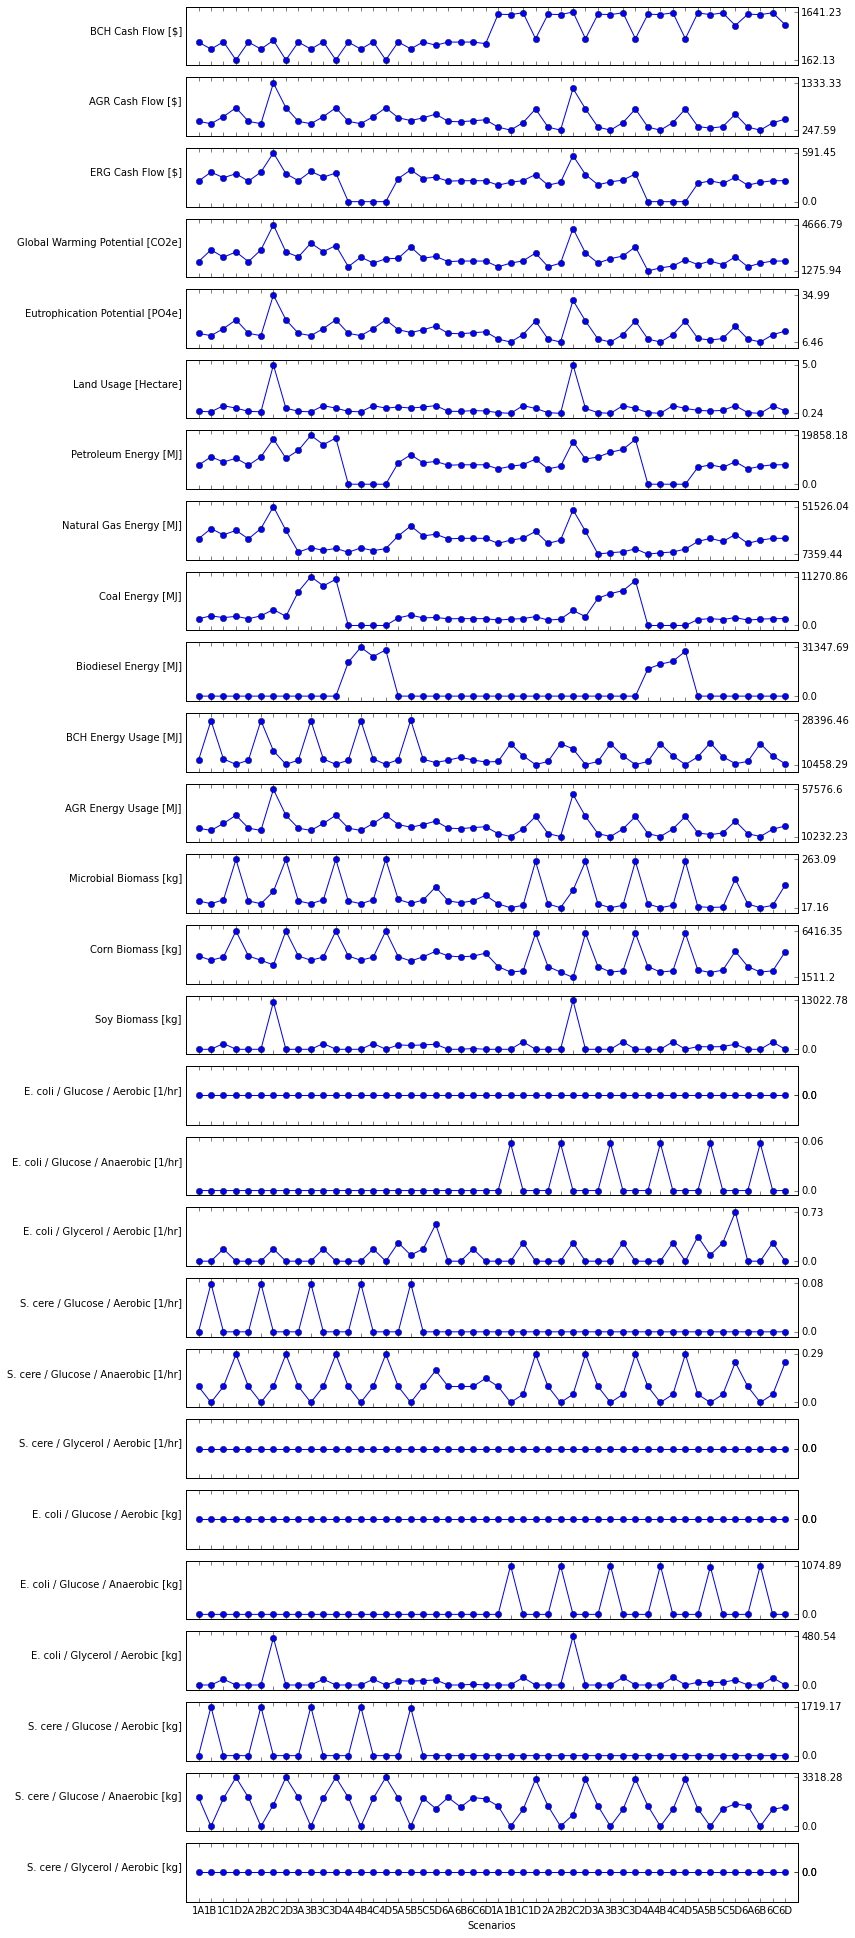

In [56]:
# Simulations based on different scenarios

model = pickle.load(open('models/mini_BChI_model.pickle','rb'))

solutions = OrderedDict()
data = OrderedDict()


for S in Scenarios.keys():
    for O in OBJs.keys():
        if 'energy=EU' in S:
            add_RC_EU_energy(model)  # add EU energy mixing constraint
        
        if 'energy=US' in S:
            add_RC_US_energy(model)  # add EU energy mixing constraint
            
        if 'rotate_crop' in S:
            add_RC_crop_rotation(model)
            
#         solutions[S, O] = FBA(model, objective={OBJs[O][0]:1}, maximize=OBJs[O][1], constraints = Scenarios[S])
        solutions[S, O] = pFBA(model, objective={OBJs[O][0]:1}, maximize=OBJs[O][1], constraints = Scenarios[S])

        
        if 'energy=EU' in S:
            remove_RC_EU_energy(model)  # add EU energy mixing constraint
        if 'energy=US' in S:
            remove_RC_US_energy(model)  # add EU energy mixing constraint
        if 'rotate_crop' in S:
            remove_RC_crop_rotation(model)
            
## plotting solutions

scenarios = range(1,7)
objectives = ['A', 'B', 'C', 'D']

reactions = ['BCH Cash Flow [$]', 'AGR Cash Flow [$]','ERG Cash Flow [$]',\
'Global Warming Potential [CO2e]', 'Eutrophication Potential [PO4e]', 'Land Usage [Hectare]',\
'Petroleum Energy [MJ]', 'Natural Gas Energy [MJ]', 'Coal Energy [MJ]', 'Biodiesel Energy [MJ]', \
'BCH Energy Usage [MJ]','AGR Energy Usage [MJ]',
'Microbial Biomass [kg]', 'Corn Biomass [kg]', 'Soy Biomass [kg]',\
'E. coli / Glucose / Aerobic [1/hr]','E. coli / Glucose / Anaerobic [1/hr]','E. coli / Glycerol / Aerobic [1/hr]',
'S. cere / Glucose / Aerobic [1/hr]','S. cere / Glucose / Anaerobic [1/hr]','S. cere / Glycerol / Aerobic [1/hr]',
'E. coli / Glucose / Aerobic [kg]','E. coli / Glucose / Anaerobic [kg]','E. coli / Glycerol / Aerobic [kg]',
'S. cere / Glucose / Aerobic [kg]','S. cere / Glucose / Anaerobic [kg]','S. cere / Glycerol / Aerobic [kg]'


]

x_labels_bottom = []
for s in scenarios:
    for o in objectives:
        x_labels_bottom.append(str(s)+o)
        
rxn_names = ['PROFIT_bch', 'PROFIT_agr', 'PROFIT_erg', 'EX_co2e_mkt', 'EX_po4e_mkt', 'EX_land_res', 'energy_from_petroleum', 'energy_from_natural_gas', 'energy_from_coal', 'energy_from_biodiesel', 'MX_bch2mkt_energy','MX_agr2mkt_energy','DM_biomass_mkt', 'corn_farming', 'soy_farming']
#row_labels = ['$_bch', '$_agr','$_erg','CO2e', 'PO4e', 'Land', 'Petroleum', 'NG', 'Coal', 'BioDiesel','E_bch','E_agr','Biomass', 'Corn', 'Soy', 'E. coli','S. cere']
row_labels = reactions
row_num = len(row_labels)

h=['ecoli','scere']
s=['glc','glyc']
f=['aero','anae']
for r in rxn_names:
    data[r] = []
#data['ecoli']=[]
#data['scere']=[]

for _h in h:
    for _s in s:
        for _f in f:
            if _s == 'glyc' and _f == 'anae':
                continue
            else:
                data[_h+'_'+_s+'_'+_f+'_mu'] = []
for _h in h:
    for _s in s:
        for _f in f:
            if _s == 'glyc' and _f == 'anae':
                continue
            else:
                data[_h+'_'+_s+'_'+_f+'_flux'] = []



    
for S in Scenarios.keys():
    for O in OBJs.keys():
        #print 'obj: ',O, 'sc: ',S
        for r in rxn_names:
            data[r].append(abs(solutions[S, O].values[r]))
        
        for _h in h:
            for _s in s:
                for _f in f:
                    if _s == 'glyc' and _f == 'anae':
                        continue
                    else:
                        data[_h+'_'+_s+'_'+_f+'_mu'].append(0)
                        data[_h+'_'+_s+'_'+_f+'_flux'].append(0)
                
        for key in solutions[S,O].values.keys():    
            if ('BPR' in key) and (solutions[S,O].values[key]>0):
                mu = float(re.findall("[_]\d+.\d+[_]", key)[0].replace('_',''))
                flux = solutions[S,O].values[key]
                if 'ecoli' in key:
                    host = 'ecoli'
                else:
                    host = 'scere'

                if 'glc' in key:
                    substrate = 'glc'
                else:
                    substrate = 'glyc'

                if 'aeroFB' in key:
                    fermenter = 'aero'
                else:
                    fermenter = 'anae'
                data[host+'_'+substrate+'_'+fermenter+'_mu'][-1] = mu
                data[host+'_'+substrate+'_'+fermenter+'_flux'][-1] = flux    
                    

plt.figure(figsize=(12,row_num))

x_labels_bottom = x_labels_bottom + x_labels_bottom
for i, r in enumerate(data.keys()):
    print r
    
    data_min = round(min(data[r]),2)
    data_max = round(max(data[r]),2)
        
    
    ax = plt.subplot(row_num, 1, i+1)
    ax.set_yticks([data_min, data_max])
    ax.set_yticklabels([data_min, data_max])
    ax.yaxis.tick_right()
    ax.set_xticks(range(0,len(x_labels_bottom)))
    
    if i == row_num-1:
        ax.set_xticklabels(x_labels_bottom)
    else:
        ax.set_xticklabels([])
    
    #ax.axis('off')
    plt.plot(data[r],'-o')
    
    plt.ylabel(row_labels[i], rotation=0, horizontalalignment='right')
    border_size = data_max*0.1
    plt.ylim((data_min-border_size , data_max+border_size))
    plt.xlim((-1, len(data[r])))
    #if r == 'ecoli' or r == 'scere':
    #    plt.ylim((0, 1))
    #else:
    #    plt.ylim((min(data[r])-border_size , max(data[r])+border_size))
plt.xlabel('Scenarios')    
plt.tight_layout()
plt.savefig('figures/constraints_vs_objectives_lineplot.png', dpi=300)
plt.savefig('figures/constraints_vs_objectives_lineplot.svg', dpi=300)


In [57]:
# Evaluating the specific bioreactor(s) used for each scenario
import csv
ofile  = open('results/bioreactors_used_in_scenarios.csv', "w")
writer = csv.writer(ofile, delimiter='|')
    
for S in Scenarios.keys():
    for O in OBJs.keys():
        sol = solutions[S,O]
        S_index = str(Scenarios.keys().index(S)%6 + 1)
        O_index = chr(OBJs.keys().index(O)+65)
        
        for key in sol.values.keys():
            if 'BPR' in key and sol.values[key] > 0:
                if 'ecoli' in key:
                    host = 'E. coli'
                else:
                    host = 'S. cerevisiae'

                if 'glc' in key:
                    substrate = 'Glucose'
                else:
                    substrate = 'Glycerol'

                if 'aeroFB' in key:
                    fermenter = 'Aerobic'
                else:
                    fermenter = 'Anaerobic'


                mu = float(re.findall("[_]\d+.\d+[_]", key)[0].replace('_',''))
                
                # export to CSV file
                writer.writerow([S_index+O_index, host, mu, substrate, fermenter, round(sol.values[key],2)])
                
                print S_index+O_index, host, mu, substrate, fermenter, round(sol.values[key],2)


1A S. cerevisiae 0.095 Glucose Anaerobic 1956.3
1B S. cerevisiae 0.079 Glucose Aerobic 1719.17
1C E. coli 0.184 Glycerol Aerobic 56.9
1C S. cerevisiae 0.095 Glucose Anaerobic 1896.24
1D S. cerevisiae 0.286 Glucose Anaerobic 3318.28
2A S. cerevisiae 0.095 Glucose Anaerobic 1956.3
2B S. cerevisiae 0.079 Glucose Aerobic 1719.17
2C E. coli 0.184 Glycerol Aerobic 465.13
2C S. cerevisiae 0.095 Glucose Anaerobic 1465.32
2D S. cerevisiae 0.286 Glucose Anaerobic 3318.28
3A S. cerevisiae 0.095 Glucose Anaerobic 1956.3
3B S. cerevisiae 0.079 Glucose Aerobic 1719.17
3C E. coli 0.184 Glycerol Aerobic 56.9
3C S. cerevisiae 0.095 Glucose Anaerobic 1896.24
3D S. cerevisiae 0.286 Glucose Anaerobic 3318.28
4A S. cerevisiae 0.095 Glucose Anaerobic 1956.3
4B S. cerevisiae 0.079 Glucose Aerobic 1719.17
4C E. coli 0.184 Glycerol Aerobic 56.9
4C S. cerevisiae 0.095 Glucose Anaerobic 1896.24
4D S. cerevisiae 0.286 Glucose Anaerobic 3318.28
5A E. coli 0.276 Glycerol Aerobic 43.19
5A S. cerevisiae 0.095 Glucose

In [58]:
## store data as Python pickle file
pickle.dump(data,  open('jar/constraint_vs_objectives.pickle','wb'))

    

In [59]:
## export data to CSV file
data_raw = pickle.load(open('jar/constraint_vs_objectives.pickle','rb'))

import csv
ofile  = open('results/constraints_vs_objectives.csv', "w")
writer = csv.writer(ofile, delimiter='|',)

for key in data_raw.keys():
    row = [key]
    for data_point in data_raw[key]:
        row.append(str(round(data_point,2)))
    print row
    writer.writerow(row)

['PROFIT_bch', '713.98', '497.13', '720.29', '162.13', '713.98', '497.13', '765.55', '162.13', '713.98', '497.13', '720.29', '162.13', '713.98', '497.13', '720.29', '162.13', '718.5', '503.17', '718.76', '615.38', '713.98', '712.13', '714.81', '663.99', '1572.97', '1560.1', '1616.45', '817.64', '1572.97', '1560.1', '1641.23', '817.64', '1572.97', '1560.1', '1616.45', '817.64', '1572.97', '1560.1', '1616.45', '817.64', '1613.19', '1558.77', '1613.57', '1223.65', '1572.97', '1560.1', '1616.3', '1245.51']
['PROFIT_agr', '450.62', '396.0', '558.61', '764.34', '450.62', '396.0', '1333.33', '764.34', '450.62', '396.0', '558.61', '764.34', '450.62', '396.0', '558.61', '764.34', '534.02', '467.81', '532.33', '615.9', '450.62', '439.27', '464.71', '485.55', '317.49', '247.59', '421.2', '735.59', '317.49', '247.59', '1208.81', '735.59', '317.49', '247.59', '421.2', '735.59', '317.49', '247.59', '421.2', '735.59', '330.66', '292.71', '329.7', '615.9', '317.49', '247.59', '416.57', '503.31']
['PRO

In [60]:
data_raw.keys()
sol.values.keys()

['EX_co2e_mkt',
 'EX_po4e_mkt',
 'EX_waste_organic_mkt',
 'EX_waste_cellulosic_mkt',
 'EX_waste_inorganic_mkt',
 'EX_lime_mkt',
 'EX_sulfuric_acid_mkt',
 'DM_glc_mkt',
 'DM_glyc_mkt',
 'DM_1,3pdo_mkt',
 'DM_3hp_mkt',
 'DM_biomass_mkt',
 'DM_soymeal_mkt',
 'DM_biodiesel_mkt',
 'DM_energy_mkt',
 'EX_land_res',
 'EX_petroleum_res',
 'EX_natural_gas_res',
 'EX_coal_res',
 'MX_res2mkt_land',
 'PROFIT_res',
 'MX_res2mkt_petroleum',
 'MX_res2mkt_natural_gas',
 'MX_res2mkt_coal',
 'MX_agr2mkt_land',
 'MX_agr2mkt_po4e',
 'MX_agr2mkt_waste_organic',
 'MX_agr2mkt_waste_cellulosic',
 'MX_agr2mkt_glc',
 'MX_agr2mkt_glyc',
 'MX_agr2mkt_soymeal',
 'MX_agr2mkt_biodiesel',
 'MX_agr2mkt_energy',
 'soy_conversion',
 'PROFIT_agr',
 'soy_crushing',
 'corn_farming',
 'corn_hydrolysis',
 'corn_wetmill',
 'soy_farming',
 'MX_erg2mkt_petroleum',
 'MX_erg2mkt_natural_gas',
 'MX_erg2mkt_coal',
 'MX_erg2mkt_co2e',
 'MX_erg2mkt_energy',
 'MX_erg2mkt_biodiesel',
 'energy_from_natural_gas',
 'PROFIT_erg',
 'energy_f

## 4.3 Plotting: Effects of Constraints and Objectives

In [3]:
import numpy
import cPickle as pickle

import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import host_subplot

from collections import OrderedDict
## Reading Raw Data
data_raw = pickle.load(open('jar/constraint_vs_objectives.pickle','rb'))

In [4]:
## Processing Data
# convert raw_data to an array of relative values
    # relative value of X = raw data of X / max value of X
data_relative = []
maximum = []
data_pdo = []
data_3hp = []
data = OrderedDict()

for key, item in data_raw.items():
    if 'mu' in key:
        row_max = 0.8
        row = numpy.array(item)/row_max
    #elif 'flux' in key:
    #    row_max = 5000
    #    row = numpy.array(item)/row_max
    else:
        row_max = int(max(item))
        if row_max != 0:
            row = numpy.array(item)/row_max
        else:
            row = numpy.array(item)*0
    data_relative.append(row)
    maximum.append(row_max)

# splitting array based on PDO and 3HP production
for item in data_relative:
    data_pdo.append(item[0:24])
    data_3hp.append(item[24:48])

# splitting the array furthur based on value type
products = ['pdo','3hp']
#data_categories = ['profit','ecosystem','energy','biomass','cell_factory_growth', 'cell_factory_flux']
# data_categories = ['profit','ecosystem','energy','biomass', 'cell_factory_flux']
data_categories = ['profit','ecosystem','energy','biomass']




data['pdo','profit'] = data_pdo[0:3]
data['pdo','ecosystem'] = data_pdo[3:6]
data['pdo','energy'] = data_pdo[6:12]
data['pdo','biomass'] = data_pdo[12:15]
data['pdo','cell_factory_growth'] = data_pdo[15:21]
data['pdo','cell_factory_flux'] = data_pdo[21:27]

data['3hp','profit'] = data_3hp[0:3]
data['3hp','ecosystem'] = data_3hp[3:6]
data['3hp','energy'] = data_3hp[6:12]
data['3hp','biomass'] = data_3hp[12:15]
data['3hp','cell_factory_growth'] = data_3hp[15:21]
data['3hp','cell_factory_flux'] = data_3hp[21:27]



In [5]:
## Preparing Figure labels & captions
# Scenarios, Objectives, Reactions
scenarios = range(1,7)
objectives = ['A', 'B', 'C', 'D']

reactions = ['BCH Cash Flow [$]', 'AGR Cash Flow [$]','ERG Cash Flow [$]',\
'Global Warming Pot. [CO2e]', 'Eutrophication Pot. [PO4e]', 'Land Usage [Hectare]',\
'Petroleum Energy [MJ]', 'Natural Gas Energy [MJ]', 'Coal Energy [MJ]', 'Biodiesel Energy [MJ]', \
'BCH Energy Usage [MJ]','AGR Energy Usage [MJ]',
'Microbial Biomass [kg]', 'Corn Biomass [kg]', 'Soy Biomass [kg]',\
'E. coli [Glucose/Aerobic] [1/hr]','E. coli [Glucose/Anaerobic] [1/hr]','E. coli [Glycerol/Aerobic] [1/hr]',
'S. cere [Glucose/Aerobic] [1/hr]','S. cere [Glucose/Anaerobic] [1/hr]','S. cere [Glycerol/Aerobic] [1/hr]',
'E. coli / Glc / Aerobic [kg]','E. coli / Glc / Anaerobic [kg]','E. coli / Glyc / Aerobic [kg]',
'S. cere / Glc / Aerobic [kg]','S. cere / Glc / Anaerobic [kg]','S. cere / Glyc / Aerobic [kg]']

x_labels_bottom = []
for s in scenarios:
    for o in objectives:
        x_labels_bottom.append(str(s)+o)

x_labels_top = []
for s in scenarios:
    for o in objectives:
        x_labels_top.append(o)



y_label = {}
y_label['pdo','profit'] = reactions[0:3]
y_label['pdo','ecosystem'] = reactions[3:6]
y_label['pdo','energy'] = reactions[6:12]
y_label['pdo','biomass'] = reactions[12:15]
y_label['pdo','cell_factory_growth'] = reactions[15:21]
y_label['pdo','cell_factory_flux'] = reactions[21:27]

y_label['3hp','profit'] = reactions[0:3]
y_label['3hp','ecosystem'] = reactions[3:6]
y_label['3hp','energy'] = reactions[6:12]
y_label['3hp','biomass'] = reactions[12:15]
y_label['3hp','cell_factory_growth'] = reactions[15:21]
y_label['3hp','cell_factory_flux'] = reactions[21:27]

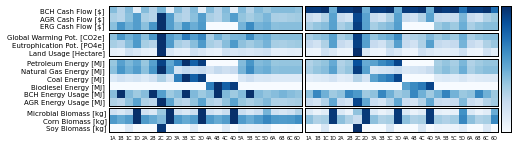

In [6]:
## Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def make_ticklabels_invisible(fig):
    for i, ax in enumerate(fig.axes):
        ax.text(0.5, 0.5, "ax%d" % (i+1), va="center", ha="center")
        for tl in ax.get_xticklabels() + ax.get_yticklabels():
            tl.set_visible(False)




fig = plt.figure(1, (7.2,7.2/48*15))

gs = gridspec.GridSpec(4, 2,
                       width_ratios=[1,1],
                       height_ratios=[3,3,6,3],
                       wspace=0.02,
                       hspace=0.1,
                       left = 0.18,
                       right=0.93
                       )
# plotting
#my_cmap = matplotlib.cm.get_cmap('copper_r')
my_cmap = matplotlib.cm.get_cmap('Blues')


plt_num = 0
for c in data_categories:
    for p in products:
        ax = plt.subplot(gs[plt_num])

        if (plt_num == 6) or (plt_num == 7):
            ax.tick_params(labelsize=5, pad = 3, left='off', right='off',top='off', bottom='off',labelbottom='on', labelleft='off',labeltop='off')
            ax.set_xticks(range(0,len(x_labels_bottom)))
            ax.set_xticklabels(x_labels_bottom)
            #ax.set_xlabel('Scenarios', fontsize=6)
        else:
            ax.tick_params(labelsize=5, pad = 5, left='off', right='off',top='off', bottom='off',labelbottom='off', labelleft='off',labeltop='off')
        
        if plt_num == 0:
            ax.xaxis.set_label_position('top')
            #ax.set_xlabel('PDO Production, Production Volume = 1 Ton', fontsize=6)
        
        if plt_num == 1:
            ax.xaxis.set_label_position('top')
            #ax.set_xlabel('3HP Production, Production Volume = 1 Ton', fontsize=6)
            
        if plt_num % 2 == 0:
            ax.tick_params(labelleft='on')
            ax.set_yticks(range(0,len(y_label[p,c])))
            ax.set_yticklabels(y_label[p,c], fontsize=7)

        im = ax.imshow(data[p,c],interpolation='nearest',origin='upper', vmin=0, vmax=1, aspect='auto', cmap=my_cmap)
#        ax.grid(True, which='both', color='w', linewidth=2, linestyle='-')
#         ax.grid(True)
        plt_num+=1

cbar_ax = fig.add_axes([0.936, 0.125, 0.02, 0.775])
cbar=fig.colorbar(im, cax=cbar_ax)
cbar_ax.tick_params(labelsize=5, left='off', right='off',top='off',labelright='off')
cbar.solids.set_edgecolor("face")
#draw()

#cbar.set_label('Relative Value', rotation=270, fontsize=7, labelpad=6)
plt.savefig('figures/constraints_vs_objectives.png', dpi=300)
plt.savefig('figures/constraints_vs_objectives.svg', dpi=300)

# 4.4 Analysis: Constraints and Solution Space

In [65]:
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import host_subplot

import numpy
import cPickle as pickle

from cbmTES.global_constants import *


from framed.analysis.variability import FVA, flux_envelope_3d
from framed.hack.ratio_constraint import *

In [66]:
### Flux Constraints ###
FCs = {}
FCs['no import'] = {'DM_glyc_mkt':(0,0), 'DM_glc_mkt':(0,0), 'DM_energy_mkt':(0,0)}
FCs['positive profits']= {'PROFIT_res':(0,None), 'PROFIT_agr':(0,None), 'PROFIT_erg':(0,None), 'PROFIT_bch':(0,None)}
FCs['product demand: pdo = 1000']= {'DM_3hp_mkt':(0, 0), 'DM_1,3pdo_mkt':(1000,1000)}
FCs['land use < 1'] = {'EX_land_res':(-1,0)}
FCs['land use < 5'] = {'EX_land_res':(-5,0)}
FCs['co2 < 3000'] = {'EX_co2e_mkt':(0, 3000)}
FCs['co2 < 2000'] = {'EX_co2e_mkt':(0, 2000)}

### Ratio Constraints ###
# EU Energy Mix
def add_RC_EU_energy(model):
    add_ratio_constraint(model, 'energy_from_petroleum', 'MX_erg2mkt_energy', 0.25)
    add_ratio_constraint(model, 'energy_from_natural_gas', 'MX_erg2mkt_energy', 0.7)
    add_ratio_constraint(model, 'energy_from_coal', 'MX_erg2mkt_energy', 0.05)
    
### Setting Up Scenarios ### 
base_scenario = {k:v for d in (FCs['no import'], FCs['positive profits']) for k, v in d.iteritems()}

# Scenario A: PDO production = 1 ton
scenario_A = base_scenario.copy()
scenario_A.update(FCs['product demand: pdo = 1000'])
scenario_A.update(FCs['land use < 5'])

# Scenario B: PDO production = 1 ton, Land use < 1 hectare
scenario_B= base_scenario.copy()
scenario_B.update(FCs['product demand: pdo = 1000'])
scenario_B.update(FCs['land use < 1'])

# Scenario C: PDO production = 1 ton, CO2 < 2000 g
scenario_C= base_scenario.copy()
scenario_C.update(FCs['product demand: pdo = 1000'])
scenario_C.update(FCs['co2 < 2000'])
#scenario_C.update(FCs['co2 < 3000'])

In [67]:
# Loading Model
model = pickle.load(open('models/mini_BChI_model.pickle','rb'))
add_RC_EU_energy(model)  # add EU energy mixing constraint

In [68]:
# Simulate Scenario A
zmins_A, zmaxs_A, x_coors_A, y_coors_A = flux_envelope_3d(model, 'PROFIT_bch','PROFIT_agr','EX_co2e_mkt', steps=15, constraints=scenario_A)

# Simulate Scenario B
zmins_B, zmaxs_B, x_coors_B, y_coors_B = flux_envelope_3d(model, 'PROFIT_bch','PROFIT_agr','EX_co2e_mkt', steps=15, constraints=scenario_B)


# Simulate Scenario C
zmins_C, zmaxs_C, x_coors_C, y_coors_C = flux_envelope_3d(model, 'PROFIT_bch','PROFIT_agr','EX_co2e_mkt', steps=15, constraints=scenario_C)

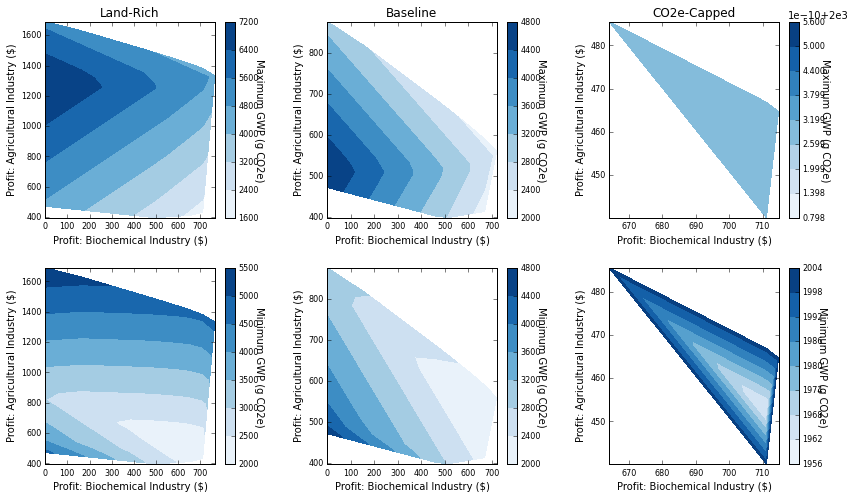

In [69]:
fig= plt.figure(1,figsize = (12,7))

#my_cmap = matplotlib.cm.get_cmap('Blues')
my_cmap = plt.cm.get_cmap('Blues')

# Plotting Scenario A
ax = plt.subplot(231)
ax.set_title('Land-Rich')
plt.contourf(x_coors_A, y_coors_A, zmaxs_A, cmap=my_cmap)
plt.xlabel('Profit: Biochemical Industry ($)')
plt.ylabel('Profit: Agricultural Industry ($)')
cbar = plt.colorbar()
cbar.set_label('Maximum GWP (g CO2e)', rotation=270)
cbar.ax.tick_params(labelsize=8)

ax = plt.subplot(234)
plt.contourf(x_coors_A, y_coors_A, zmins_A, cmap=my_cmap)
plt.xlabel('Profit: Biochemical Industry ($)')
plt.ylabel('Profit: Agricultural Industry ($)')
cbar = plt.colorbar()
cbar.set_label('Minimum GWP (g CO2e)', rotation=270)
cbar.ax.tick_params(labelsize=8)


# Plotting Scenario B
ax = plt.subplot(232)
ax.set_title('Baseline')
plt.contourf(x_coors_B, y_coors_B, zmaxs_B, cmap=my_cmap)
plt.xlabel('Profit: Biochemical Industry ($)')
plt.ylabel('Profit: Agricultural Industry ($)')
cbar = plt.colorbar()
cbar.set_label('Maximum GWP (g CO2e)', rotation=270)
cbar.ax.tick_params(labelsize=8)

ax = plt.subplot(235)
plt.contourf(x_coors_B, y_coors_B, zmins_B, cmap=my_cmap)
plt.xlabel('Profit: Biochemical Industry ($)')
plt.ylabel('Profit: Agricultural Industry ($)')
cbar = plt.colorbar()
cbar.set_label('Minimum GWP (g CO2e)', rotation=270)
cbar.ax.tick_params(labelsize=8)

# Plotting Scenario C
ax = plt.subplot(233)
ax.set_title('CO2e-Capped')
plt.contourf(x_coors_C, y_coors_C, zmaxs_C, cmap=my_cmap)
plt.xlabel('Profit: Biochemical Industry ($)')
plt.ylabel('Profit: Agricultural Industry ($)')
cbar = plt.colorbar()
cbar.set_label('Maximum GWP (g CO2e)', rotation=270)
cbar.ax.tick_params(labelsize=8)

ax = plt.subplot(236)
plt.contourf(x_coors_C, y_coors_C, zmins_C, cmap=my_cmap)
plt.xlabel('Profit: Biochemical Industry ($)')
plt.ylabel('Profit: Agricultural Industry ($)')
cbar = plt.colorbar()
cbar.set_label('Minimum GWP (g CO2e)', rotation=270)
cbar.ax.tick_params(labelsize=8)

# set figure properties
for i in [1,2,3,4,5,6]:
    ax = plt.subplot(2,3,i)
    ax.xaxis.label.set_fontsize(10)
    ax.yaxis.label.set_fontsize(10)
    ax.tick_params(labelsize=8)
    #ax.set_xlim([0, 1100])
plt.tight_layout(w_pad=3,h_pad=2)

plt.savefig('figures/constraints_vs_solution_space.png', dpi=600)
plt.savefig('figures/constraints_vs_solution_space.svg')

## 4.5 Generic Analysis of Model Structure

In [70]:
import cPickle as pickle

In [71]:
model = pickle.load(open('models/mini_BChI_model.pickle','rb'))

In [72]:
total_rxn_num = 0
BPR_rxn_num = 0
MX_rxn_num = 0
EX_rxn_num = 0
DM_rxn_num = 0
CF_rxn_num = 0




for rxn_name in model.reactions.keys():
    total_rxn_num += 1

    if 'BPR' in rxn_name:
        BPR_rxn_num += 1
    
    if 'MX' in rxn_name:
        MX_rxn_num += 1
        
    if 'EX' in rxn_name:
        EX_rxn_num += 1
        
    if 'DM' in rxn_name:
        DM_rxn_num += 1
    
    if 'PROFIT' in rxn_name:
        CF_rxn_num += 1    
    
        
print "The economic model contains a total of ", total_rxn_num, ' reactions'
print "The economic model contains ", BPR_rxn_num, ' bioprocess reactions'
print "The economic model contains ", MX_rxn_num, ' trade reactions'
print "The economic model contains ", EX_rxn_num, ' emission and resource consumption reactions'
print "The economic model contains ", DM_rxn_num, ' market demand reactions'
print "The economic model contains ", CF_rxn_num, ' cashflow reactions'
print "The economic model contains ", total_rxn_num - BPR_rxn_num - MX_rxn_num - EX_rxn_num - DM_rxn_num - CF_rxn_num, ' other transformation reactions'






The economic model contains a total of  160  reactions
The economic model contains  96  bioprocess reactions
The economic model contains  30  trade reactions
The economic model contains  11  emission and resource consumption reactions
The economic model contains  8  market demand reactions
The economic model contains  4  cashflow reactions
The economic model contains  11  other transformation reactions


In [73]:
print model

EX_co2e_mkt: co2e_mkt <-> 
EX_po4e_mkt: po4e_mkt <-> 
EX_waste_organic_mkt: waste_organic_mkt <-> 
EX_waste_cellulosic_mkt: waste_cellulosic_mkt <-> 
EX_waste_inorganic_mkt: waste_inorganic_mkt <-> 
EX_lime_mkt: lime_mkt <-> 
EX_sulfuric_acid_mkt: sulfuric_acid_mkt <-> 
DM_glc_mkt: glc_mkt <-> 0.43 dollar_mkt
DM_glyc_mkt: glyc_mkt <-> 0.18 dollar_mkt
DM_1,3pdo_mkt: 1,3pdo_mkt <-> 1.8 dollar_mkt
DM_3hp_mkt: 3hp_mkt <-> 2.4 dollar_mkt
DM_biomass_mkt: biomass_mkt <-> 
DM_soymeal_mkt: soymeal_mkt <-> 
DM_biodiesel_mkt: biodiesel_mkt <-> 0.9072 dollar_mkt
DM_energy_mkt: energy_mkt <-> 0.02 dollar_mkt
EX_land_res: land_res <-> 
EX_petroleum_res: petroleum_res <-> 
EX_natural_gas_res: natural_gas_res <-> 
EX_coal_res: coal_res <-> 
MX_res2mkt_land: land_res + 41 dollar_mkt <-> land_mkt + 41 dollar_res
PROFIT_res: dollar_res <-> 
MX_res2mkt_petroleum: petroleum_res + 0.765 dollar_mkt <-> petroleum_mkt + 0.765 dollar_res
MX_res2mkt_natural_gas: natural_gas_res + 0.5628 dollar_mkt <-> natural_ga

# 4.6 Analysis: Constraints and Solution Space 3D

In [74]:
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import host_subplot

import numpy
import cPickle as pickle

from cbmTES.global_constants import *


from framed.analysis.variability import FVA, flux_envelope_3d
from framed.hack.ratio_constraint import *

In [75]:
### Flux Constraints ###
FCs = {}
FCs['no import'] = {'DM_glyc_mkt':(0,0), 'DM_glc_mkt':(0,0), 'DM_energy_mkt':(0,0)}
FCs['positive profits']= {'PROFIT_res':(0,None), 'PROFIT_agr':(0,None), 'PROFIT_erg':(0,None), 'PROFIT_bch':(0,None)}
FCs['product demand: pdo = 1000']= {'DM_3hp_mkt':(0, 0), 'DM_1,3pdo_mkt':(1000,1000)}
FCs['land use < 1'] = {'EX_land_res':(-1,0)}
FCs['land use < 5'] = {'EX_land_res':(-5,0)}
FCs['co2 < 3000'] = {'EX_co2e_mkt':(0, 3000)}
FCs['co2 < 2000'] = {'EX_co2e_mkt':(0, 2000)}

### Ratio Constraints ###
# EU Energy Mix
def add_RC_EU_energy(model):
    add_ratio_constraint(model, 'energy_from_petroleum', 'MX_erg2mkt_energy', 0.25)
    add_ratio_constraint(model, 'energy_from_natural_gas', 'MX_erg2mkt_energy', 0.7)
    add_ratio_constraint(model, 'energy_from_coal', 'MX_erg2mkt_energy', 0.05)
    
### Setting Up Scenarios ### 
base_scenario = {k:v for d in (FCs['no import'], FCs['positive profits']) for k, v in d.iteritems()}

# Scenario A: PDO production = 1 ton, Land use < 5 hectare
scenario_A = base_scenario.copy()
scenario_A.update(FCs['product demand: pdo = 1000'])
scenario_A.update(FCs['land use < 5'])

# Scenario B: PDO production = 1 ton, Land use < 1 hectare
scenario_B= base_scenario.copy()
scenario_B.update(FCs['product demand: pdo = 1000'])
scenario_B.update(FCs['land use < 1'])

# Scenario C: PDO production = 1 ton, CO2 < 2000 g
scenario_C= base_scenario.copy()
scenario_C.update(FCs['product demand: pdo = 1000'])
scenario_C.update(FCs['co2 < 2000'])
#scenario_C.update(FCs['co2 < 3000'])

In [76]:
# Loading Model
model = pickle.load(open('models/mini_BChI_model.pickle','rb'))
add_RC_EU_energy(model)  # add EU energy mixing constraint

In [77]:
# Simulate Scenario A
zmins_A, zmaxs_A, x_coors_A, y_coors_A = flux_envelope_3d(model, 'PROFIT_bch','PROFIT_agr','EX_co2e_mkt', steps=15, constraints=scenario_A)

# Simulate Scenario B
zmins_B, zmaxs_B, x_coors_B, y_coors_B = flux_envelope_3d(model, 'PROFIT_bch','PROFIT_agr','EX_co2e_mkt', steps=15, constraints=scenario_B)


# Simulate Scenario C
zmins_C, zmaxs_C, x_coors_C, y_coors_C = flux_envelope_3d(model, 'PROFIT_bch','PROFIT_agr','EX_co2e_mkt', steps=15, constraints=scenario_C)

xA = x_coors_A + x_coors_A
yA = y_coors_A + y_coors_A
zA = zmaxs_A + zmins_A

xB = x_coors_B + x_coors_B
yB = y_coors_B + y_coors_B
zB = zmaxs_B + zmins_B

xC = x_coors_C + x_coors_C
yC = y_coors_C + y_coors_C
zC = zmaxs_C + zmins_C

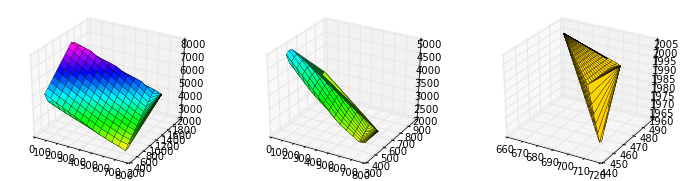

In [78]:
from mpl_toolkits.mplot3d import Axes3D
fig= plt.figure(1,figsize = (12,3))

my_cmap = plt.cm.get_cmap('hsv')


ax = fig.add_subplot(131, projection='3d')
ax.plot_surface(xA, yA, zA, cmap=my_cmap, rstride = 1, cstride = 1, linewidth=0.3, vmin = 1000, vmax = 8000)
# ax.contour(xA, yA, zA, 20, cmap=my_cmap, rstride = 1, cstride = 1, linewidth=0.3, vmin = 1000, vmax = 8000)
#ax.locator_params(nbins=5)

ax = fig.add_subplot(132, projection='3d')
ax.plot_surface(xB, yB, zB, cmap=my_cmap, rstride = 1, cstride = 1, linewidth=0.3, vmin = 1000, vmax = 8000)
# ax.locator_params(nbins=5)

ax = fig.add_subplot(133, projection='3d')
ax.plot_surface(xC, yC, zC, cmap=my_cmap, rstride = 1, cstride = 1, linewidth=0.3, vmin = 1000, vmax = 8000)
# ax.set_xlim(0, 1000)
# ax.set_ylim(0, 2000)


# ax.locator_params(nbins=5)


plt.savefig('figures/constraints_vs_solution_space3d.png', dpi=600)
plt.savefig('figures/constraints_vs_solution_space3d.svg')

<matplotlib.contour.QuadContourSet instance at 0x115d8b758>

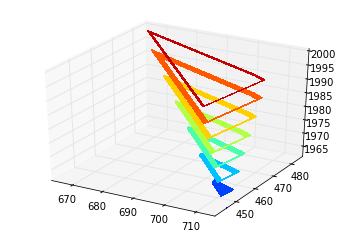

In [79]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.contourf(x_coors_C, y_coors_C, zmins_C)

In [13]:
import pandas as pd

In [14]:
profit = pd.DataFrame(data['pdo','profit'])

In [15]:
profit

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.435090,0.302943,0.438934,0.098802,0.435090,0.302943,0.466514,0.098802,0.435090,0.302943,...,0.438934,0.098802,0.437841,0.306626,0.437998,0.375006,0.435090,0.433962,0.435591,0.404623
1,0.338047,0.297071,0.419060,0.573395,0.338047,0.297071,1.000247,0.573395,0.338047,0.297071,...,0.419060,0.573395,0.400617,0.350946,0.399344,0.462041,0.338047,0.329535,0.348622,0.364255
2,0.419602,0.605639,0.490700,0.572893,0.419602,0.605639,1.000754,0.572893,0.429855,0.620438,...,0.000000,0.000000,0.472738,0.651651,0.473397,0.502593,0.419602,0.428883,0.428883,0.428883


In [20]:
writer = pd.ExcelWriter('/Users/kaizhuang/Dropbox/CfB/research/MuSIC_pdo_3hp/results/profit.xlsx')
profit.to_excel(writer,'Prices')

# formatting EXCEL file
sheet = writer.book.worksheets()[0]


In [17]:
pwd

u'/Users/kaizhuang/Dropbox/CfB/research/MuSIC_pdo_3hp'

In [18]:
ls

README
S1_metabolism.ipynb
S2_bioreactor.ipynb
S3_bioprocess.ipynb
S4_economy.ipynb
S5_economy2metabolism.ipynb
S6_eco_env_tradeoffs.ipynb
X1_flux_variability.ipynb
X2_sensitivity_product_tolerance.ipynb
X3_sensitivity_purification_efficiency.ipynb
build/
cbmTES/
figures/
gurobi (kais-mac-mini.home's conflicted copy 2015-04-14).log
gurobi.log
jar/
lib/
models/
old_ipython_notebooks/
references/
results/


In [19]:
ls results/

bioreactors_used_in_scenarios.csv  rxn.csv
constraints_vs_objectives.csv      scere_active_pathways.csv
ecoli_active_pathways.csv
